# Implementing a Multilayer Feed Forward Network with NumPy

**Imports**

In [1]:
import numpy as np
import scipy.stats

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt

Get the specs:

In [2]:
print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available()) 
print('GPU:', tf.config.list_physical_devices('GPU'))

Keras 2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU: True
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Use Functions!
Most code online does this using pure math.  
Devide the calculations into functions.

**Math Layers**

In [3]:
def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

def ReLU(X):
    return np.maximum(X, 0)

def dReLU(X):
    return (X > 0).astype(float)

def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

**Dense Layer**

In [4]:
def fully_connected(n_inputs, n_outputs):
    boundary = np.sqrt(6 / (n_inputs + n_outputs))
    return np.random.uniform(-boundary, boundary, size=(n_inputs, n_outputs))

**Forward Pass**

In [5]:
def feed_forward(Ws, X, keep_prob=1): ###
    
    # input layer
    layers = [X] 

    # hidden layers
    for i,w in enumerate(Ws[:-1]):
        X = X @ w
        X = drop(X,keep_prob)
        X = ReLU(X)
        layers.append(X)
    
    # final layer
    X = X @ Ws[-1]
    X = softmax(X)
    layers.append(X)

    return layers   
    

**Backward Pass**

In [6]:
def back_propagation(Ws, X, Y, keep_prob=1): ###
    
    gradients = []
    layers = feed_forward(Ws,X,keep_prob) 
    
    # output layer
    y_hat = layers.pop() 
    δ = y_hat - Y
    
    for i in range(1,len(Ws)+1):
        z = layers.pop()

        # get the gradients
        gradients.append(z.T @ δ) 

        # stop when reaching input layer - to save computations
        if i == len(Ws):
            break

        # get the layer's loss
        δ = δ @ Ws[-i].T 

        # get the activation derivative
        δ *= dReLU(z)

    # reverse the order
    gradients.reverse()

    # sanity checks
    assert len(gradients) == len(Ws), (len(gradients), len(Ws))
    for dW, W in zip(gradients, Ws):
        assert dW.shape == W.shape, (dW.shape, W.shape)
    return gradients

**Loss**

In [7]:
def loss(Ws, X, Y):
    Yhat = predict(Ws, X)
    return cross_entropy(Yhat, Y)

**Optimizer**

In [8]:
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = self.average(self.m, gradients, self.β1)        
        self.v = self.average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates
    
    def average(self,prev, curr, β):
        return [
            β * p + (1 - β) * c
            for p, c
            in zip(prev, curr)
        ]

**Gradients check by math operations (optional)**

In [9]:
def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y, keep_prob=1)
    Ws_ = [W.copy() for W in Ws]

    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)

**Predictions**

In [29]:
def predict(Ws, X):
    if X.ndim == 1:
        X = X.reshape((1, -1))
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print('Prediction:', prediction)
    print('True Label:', Y_test[idx], ' ==> ',Y_test[idx].argmax())
    return display_image(X_test[idx])

**Batch Training Loop**

In [11]:
def trainer(Ws, X, Y, optimizer, batch_size=50, keep_prob=1):    
    nsamples = X.shape[0]
    batch = 0
    while True:
        # get next batch
        start = (batch * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = range(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        
        # calculate gradients
        gradients = back_propagation(Ws, X_, Y_, keep_prob=keep_prob) 
        
        # calculate updates
        ΔWs = optimizer.send(gradients) 
        
        # apply updates
        for W, ΔW in zip(Ws, ΔWs): 
            W += ΔW
            
        batch += 1
        yield batch

In [12]:
# Let's load the data for MNIST digits.
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

Y_train.shape,X_train.shape

((60000, 10), (60000, 784))

## Create Network

I can choose how many Dense Layers to use...

For example:  
input shape ==> 64 ==> 32 ==> 10 (number of labels)



In [13]:
W1 = fully_connected(X_train.shape[1],64)
W2 = fully_connected(64,32)
W3 = fully_connected(32,10)
Ws = [W1, W2, W3]

## Create Trainer

In [14]:
batch_size = 100

train = trainer(Ws, X_train, Y_train, batch_size=batch_size, optimizer=AdamOptimizer())

## Initial Prediction
with no training at all

In [15]:
acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy: {:.4f}".format(acc))

Accuracy: 0.1093


## Training

In [16]:
epochs = 10

for batch in train:
    if batch == (epochs * nsamples // batch_size) : 
        break

## Check Predictions

In [17]:
acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy ({:d}): {:.4f}".format(batch, acc))

Accuracy (6000): 0.9395


**Visualize prediction**

Prediction: 8
True Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]  ==>  8


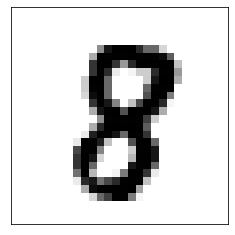

In [91]:
n_random = np.random.randint(len(X_test))
display_prediction(n_random)

Prediction: 6
True Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  ==>  2


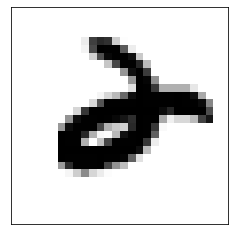

In [77]:
n_random = np.random.randint(len(X_test))
display_prediction(n_random)